In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

In [4]:
class BrineThermodynamics:
    
    def __init__(self, MW:float, nu:tuple, z:tuple, B_0:float, B_1:float, \
                 C_phi:float, DG0:float, DH0:float, K:float, n:float):
        #Parameters specific to Magnesium Perchlorate
        self.MW = MW #Molecular weight, in kg/mol
        self.nu = nu #Moles of (cation/anion) per mole of salt
        self.z = z #Charge of cation, anion
        self.B_0 = B_0 #Pitzer ionic constants
        self.B_1 = B_1
        self.C_phi = C_phi
        self.DG0 = DG0 #Gibbs free energy of dissolution, at 298 K and 1 bar
        self.DH0 = DH0 #Enthalpy of dissolution, at 298 K and 1 bar
        self.K = K #Equilibrium constant for dissolution
        self.n = n #number of water molecules in solid salt crystal

    #Convert between weight % and molal for a given Molecular Weight (kg/mol)
    def wp2molal(self, wtperc):
        return 1 / self.MW * (wtperc / (1-wtperc))
    def molal2wp(self, molal):
        return self.MW * molal / (1+self.MW*molal)

    #Ionic strength calculated from salt concentration in solution
    def getIs(self,m_salt): 
        mi_zi2 = 0
        for i in range(len(self.z)):
            mi_zi2 += m_salt*self.nu[i]*self.z[i]**2 #sum recursively over all ions & concentrations
        I = 0.5*mi_zi2       
        return I      

    #Debye-Huckle & Pitzer parameters (Stokes, 1991)
    def getA(self,T): #Temperature dependent Debye-Huckle coefficient
        return 0.13422*(0.0368329*T - 14.62718*np.log(T) - 1530.1474/T + 80.40631)

    def getf(self,m_salt,T): 
        Is = self.getIs(m_salt)
        b = 1.2 #universal Pitzer parameter, kg / mol^1/2
        return -self.getA(T) * np.sqrt(Is) / (1 + b*np.sqrt(Is))

    def getB(self,m_salt): 
        Is = self.getIs(m_salt)
        return self.B_0 + self.B_1*np.exp(-2 * np.sqrt(Is) )

    #Calculate Osmotic coefficient (Phi), using Pitzer virial coefficients B and C_phi (Stokes, 1991)
    def getPhi(self,m_salt,T):   
        Phi = 1 + abs(self.z[0] * self.z[1]) * self.getf(m_salt,T) + \
              m_salt * self.getB(m_salt) * (2*self.nu[0]*self.nu[1]/(self.nu[0] + self.nu[1])) + \
              m_salt**2 * self.C_phi * (2*(self.nu[0] * self.nu[1])**(3/2) / (self.nu[0] + self.nu[1]))
        return Phi

    #Calculate water activity (a_w) from osmotic coefficient (phi) (Stokes, 1991)
    def getaw(self,m_salt,T):
        #Sum over mk (molality of all ions)
        sum_mk = 0
        for j in range(len(self.nu)):
            sum_mk += self.nu[j] * m_salt    
        aw = np.exp( -self.getPhi(m_salt,T) * sum_mk / (55.10) )  # a_w = Exp[ - Phi * Sum(m_k) / Omega ]
        return aw
    
    #Calculate freezing temperature depression from water activity (Chevrier, 2009)
    def getDHf(self,aw): #temperature-dependent enthalpy of fusion
        DHf = 3.34768 - 1.85714/(1 + np.exp((aw - 0.53822)/0.05031)) + 1.85921*aw\
                + 2.51524*aw**2 - 1.72933*aw**3  #Equation (4) in the Chevrier 2009 supp. material is wrong. 2nd term needs to be negative.
        return DHf * 1000 #Convert kJ -> J

    def getTe(self,aw): #Eutectic temperature
        DHf = self.getDHf(aw)
        R = 8.31446261815324 #J K^-1 mol^-1; gas constant
        Te = ((1/273.15) - (R * np.log(aw)) / DHf)**(-1) #Eqn 2 from Chevrier et al 2009 supp. material
        return Te


In [5]:
#Create an instance for Magnesium Perchlorate
mg_pct = BrineThermodynamics(MW = 0.223206, #Molecular weight, in kg/mol
                        nu = (1,2), #Moles of (cation, anion) per mole of salt
                        z = (2,1), #Charge of (cation, anion)
                        B_0 = 0.4961, #Pitzer ionic constants
                        B_1 = 2.0085,
                        C_phi = 0.00958, #Why is this double the value in Pitzer's book???
                        DG0 = -20,
                        DH0 = 5.4,
                        K = 3200,
                        n = 6,
                        )

#Create an instance for Sodium Perchlorate
na_pct = BrineThermodynamics(MW = 0.12244, #Molecular weight, in kg/mol
                        nu = (1,1), #Moles of (cation/anion) per mole of salt
                        z = (1,1), #Charge of cation, anion
                        B_0 = 0.0554, #Pitzer ionic constants
                        B_1 = 0.2755,
                        C_phi = -0.00118,
                        DG0 = -13,
                        DH0 = 12.5,
                        K = 189.5,
                        n = 2,
                        )

Examples for using these equations:
Plot the freezing temperature of Na- and Mg-Perchlorate brine as a function of temperature:

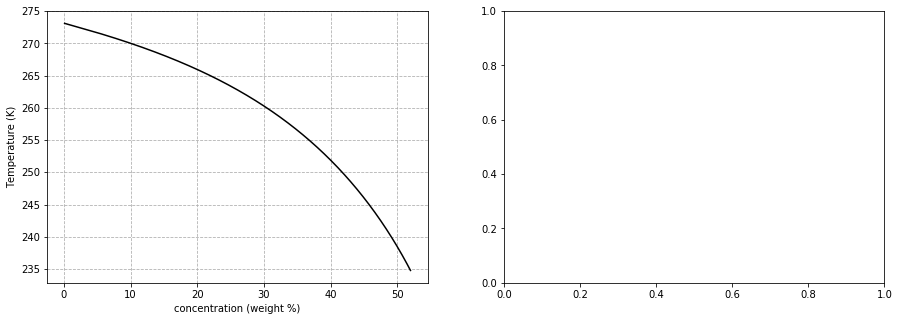

In [20]:
#Plot NaClO4 freezing temp
conc = np.linspace(0.001,0.52,1000) #concentration (in weight %) between 0% and 52% (eutectic concentration)

Telist = []
for i in range(len(conc)):
    mi = na_pct.wp2molal(conc[i]) #convert weight percent to molal
    awi = na_pct.getaw(mi,273.16) #find water activity from molal
    Tei = na_pct.getTe(awi) #calculate eutectic temp from a_w
    Telist.append(Tei)
    
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(conc*100,Telist,c='k')
ax[0].set_xlabel('concentration (weight %)')
ax[0].set_ylabel('Temperature (K)')
ax[0].grid(which='both',ls="--")

plt.show()

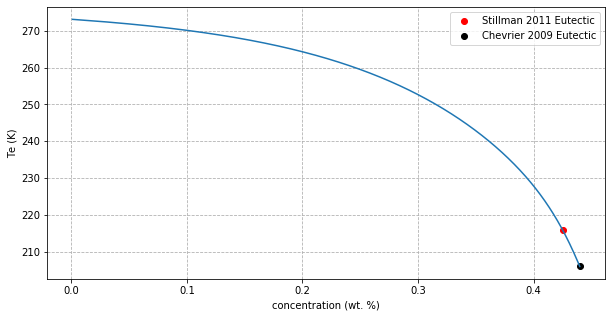

In [215]:
#calculate corresponding water activities (aw) & eutectic temps (Te)
# R = 8.31446261815324 #J K^-1 mol^-1; gas constant
T0 = 273.15 #K, freezing point of water [Side note: @ Mars pressure (~6mbar), T0 = 273.16K]

mlist = [] 
awlist=[]
Telist=[]
DHflist=[]
clist= np.linspace(0.001, 0.44,1000) #Define a range of concentrations. Don't go above ~90%, or rounding errors with low aw will throw a divided by zero error.
for i in range(len(clist)):
    mi = mg_pct.wp2molal(clist[i])#convert to wt. percent
    awi = mg_pct.getaw(mi,273.16) #water activity
    Tei = mg_pct.getTe(awi)
    
    mlist.append(mi)
    awlist.append(awi)
    Telist.append(Tei)
    DHflist.append(mg_pct.getDHf(awi))

#Plot Eutectic temp. vs. Concentration
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(clist,Telist)
ax.set_xlabel('concentration (wt. %)')
ax.set_ylabel('Te (K)')
ax.grid(which='both',ls="--")
ax.legend()

plt.show()

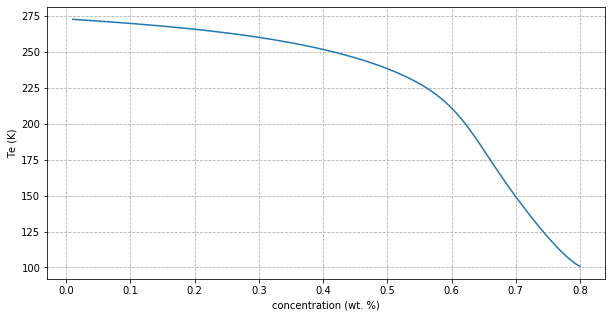

In [212]:
#calculate corresponding water activities (aw) & eutectic temps (Te)
# R = 8.31446261815324 #J K^-1 mol^-1; gas constant
T0 = 273.15 #K, freezing point of water [Side note: @ Mars pressure (~6mbar), T0 = 273.16K]

mlist = [] 
awlist=[]
Telist=[]
DHflist=[]
clist= np.linspace(0.01, 0.8,500) #Define a range of concentrations. Don't go above ~90%, or rounding errors with low aw will throw a divided by zero error.
for i in range(len(clist)):
    mi = na_pct.wp2molal(clist[i])#convert to wt. percent
    awi = na_pct.getaw(mi,273.16) #water activity
    mlist.append(mi)
    awlist.append(awi)
    Telist.append(mg_pct.getTe(awi))
    DHflist.append(mg_pct.getDHf(awi))

#Plot Eutectic temp. vs. Concentration
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(clist,Telist)
ax.set_xlabel('concentration (wt. %)')
ax.set_ylabel('Te (K)')
ax.grid(which='both',ls="--")

plt.show()

In [253]:
#This is a tool to compare against Stokes (1946) Table 3 to make sure Phi is being calculated correctly.
T = 298.15 #Kelvin
mlist = [0.1,0.15,.2,.3,.4,.5,.6,.7,.8,.9,1,1.2,1.4,1.6,1.8,2.0,2.5,3,3.5,4,4.4] #these are the molal values Stokes uses in the paper.

df = pd.DataFrame(columns=['m','phi','gamma'])
df['m']=mlist
for i in range(len(mlist)):
    df.iloc[i,1] = mg_pct.getPhi(mlist[i],T)
    
    awi = mg_pct.getaw(mlist[i],T)
    df.iloc[i,2] = awi
# df